<a href="https://colab.research.google.com/github/Ken-huea/Time-series-analysis/blob/main/SARIMAX%E3%81%AE%E3%81%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実装

### データ読み込みと分割
index col

In [ ]:
#いろいろインポート
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# 予測用モジュールのインポート
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd


#データ読み込み
# df = pd.read_csv("/content/3-3_TS_sample2.csv",index_col="年月日",encoding="shift_jis",parse_dates=True)
df = pd.read_csv("/content/SARIMAXの実装.csv",encoding="shift_jis")

df

,年月日,平均気温(℃),降水量の合計(mm),日照時間(時間)
0,2010/1/1,4.8,0.0,9.2
1,2010/1/2,6.3,0.0,9.0
2,2010/1/3,5.7,0.0,6.6
3,2010/1/4,6.5,0.0,5.2
4,2010/1/5,7.3,2.5,8.1
...,...,...,...,...
3647,2019/12/27,8.7,0.5,6.5
3648,2019/12/28,6.8,0.0,8.8
3649,2019/12/29,7.0,0.0,8.3
3650,2019/12/30,6.7,0.5,0.0


### データの整形

In [ ]:
# weather_df["年月日"]をdatetimeに変換した後、indexに格納します。
# それが完了したらカラムの["年月日"]はいらないのでドロップしましょう。
df.index = pd.to_datetime(df["年月日"], infer_datetime_format=True) 
df = df.drop(columns = ["年月日"])
df

# 上記のコードはこういうものなんだと割り切って頂ければ。

,平均気温(℃),降水量の合計(mm),日照時間(時間)
年月日,,,
2010-01-01,4.8,0.0,9.2
2010-01-02,6.3,0.0,9.0
2010-01-03,5.7,0.0,6.6
2010-01-04,6.5,0.0,5.2
2010-01-05,7.3,2.5,8.1
...,...,...,...
2019-12-27,8.7,0.5,6.5
2019-12-28,6.8,0.0,8.8
2019-12-29,7.0,0.0,8.3


今回もデータをまとめます。一日毎に予測するのではなく、
<font color="red">毎月の平均気温毎に予測</font>するようにしましょう。

1.   データ数を圧縮できる。
2.   それにより学習時間も削減できる。

In [ ]:
df = df.resample("M").mean()
# data = weather_df.resample("W").mean() #⇒こうすれば1週間ごとになります。　お好みで。

df

,平均気温(℃),降水量の合計(mm),日照時間(時間)
年月日,,,
2010-01-31,7.022581,0.290323,7.158065
2010-02-28,6.500000,4.107143,4.225000
2010-03-31,9.096774,4.629032,4.509677
2010-04-30,12.393333,7.133333,4.663333
2010-05-31,18.951613,3.677419,6.412903
...,...,...,...
2019-08-31,28.396774,3.548387,6.058065
2019-09-30,25.060000,6.566667,4.586667
2019-10-31,19.425806,17.080645,3.638710


### データ分割

In [ ]:
train=df[:int(len(df)*0.9)] # この長さまで。
test=df[int(len(df)*0.9):] # この長さ以降。

test_temp= df[["平均気温(℃)"]][int(len(df)*0.9):] # この長さ以降。 

### 学習

変数の設定。SARIMAXのX部分の設定を行います。 今回は予測する材料としてtrainの降水量と日照時間を用います。

ソロの予測のSARIMAとどのくらい差がつくのでしょうか？

In [ ]:
# 予測に用いる材料。SARIMAXのX｡
X = train[["降水量の合計(mm)","日照時間(時間)"]]

# 予測を行うデータ。毎月の平均気温を予測するモデルを作成するので、trainのラベル(y)を準備します。
y = train[["平均気温(℃)"]]

SARIMAX(endog = y, exog = X, order = param, seasonal_order = param_seasonal)
はこのような概要です。

一番右の<font color="red">周期性</font>のみちゃんと設定する必要があります。一年周期なので12で平気です。

引数の設定に是非チューニングもしてみましょう。　 これはチューニング用の独自関数で他所から引っ張てきました。

In [ ]:
import itertools
p = q = range(0, 3)
sp = sd = sq = range(0, 2)
#p,q,sp,sd,sqの組み合わせのリストを作成する。和分=1,周期=12は固定
pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))] # 3*3 9パターン　

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))] # 2*2*2 8パターン　　72パターン。

list(itertools.product(range(0,3),range(0,3)))

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [ ]:
# worningの無視。
import warnings
warnings.filterwarnings("ignore")

# AICが低かったら更新すると。

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y,X, order = param, seasonal_order = param_seasonal)
            results = mod.fit()
            print('ARIMAパラメータ{}, 季節変動パラメータ{} - AIC: {}'.format(param, param_seasonal, results.aic))
            
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue

print('AIC最小のモデル：', best_result)
# AIC最小のモデル： [(1, 1, 1), (0, 1, 1, 12), 295.51344145651655]

In [ ]:
# 是非グリッドサーチで探索したパラメータを投入してみましょう。
sarimax_model = SARIMAX(y,X, order=(1,1,2),seasonal_order=(1,0,1,12))

In [ ]:
# 学習
result_sarimax = sarimax_model.fit()

# これで概要を確認する事が出来ます。
result_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              平均気温(℃)   No. Observations:                  108
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -177.543
Date:                              Sat, 10 Sep 2022   AIC                            371.086
Time:                                      13:56:13   BIC                            392.469
Sample:                                  01-31-2010   HQIC                           379.755
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
降水量の合計(mm)    -0.0020      0.033     -0.062      0.950      -0.066       0.062
日照時間(時間)       0.3190      0.135      2.357      0.018       0.054       0.584
ar.L1          0.4477      0.155      2.880      0.004       0.143       0.752
ma.L1         -1.0348      0.748     -1.383      0.167      -2.501       0.431
ma.L2          0.0378      0.106      0.357      0.721      -0.169       0.245
ar.S.L12       0.9980      0.002    416.582      0.000       0.993       1.003
ma.S.L12      -0.7109      0.154     -4.622      0.000      -1.012      -0.409
sigma2         1.0572      0.864      1.224      0.221      -0.636       2.750
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.99   Prob(JB):                         0.79
Heteroskedasticity (H):               0.75   Skew:                             0.09
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 可視化

予測時も同様に外部変数を加えます。


```
exog=df_month_pred[["降水量の合計(mm)","日照時間(時間)"]]
```



In [ ]:
len(test)

12

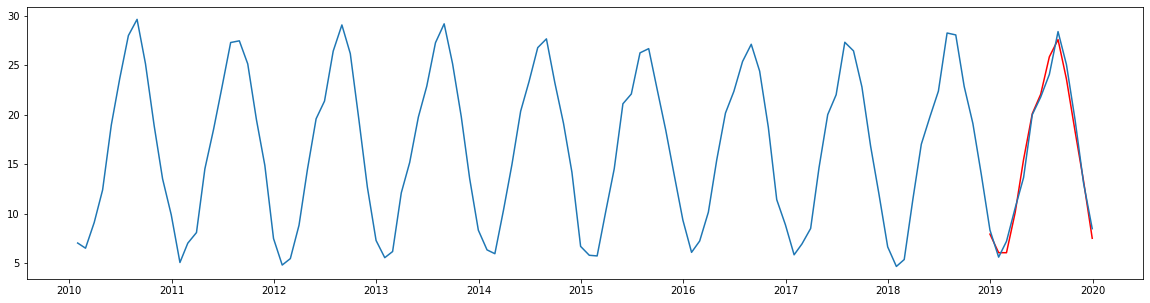

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5))

bestPred = result_sarimax.predict('2018-12', '2019-12',exog=test[["降水量の合計(mm)","日照時間(時間)"]])
plt.plot(bestPred, "r")                                     # 赤線。モデルが予測した数値。
plt.plot(df["平均気温(℃)"])                      #青線。実測値

### rmse確認

まずはtest_yとbestPred_rmseのdf形式を統一しましょう。

そうしなければきちんとrmseを算出する事が出来ません。

bestPredをdf化して新たな変数に格納します。

そしてカラムも統一しています。　　確認がとれたらrmse算出を行いましょう。

In [ ]:
#予測データの作成
#データをpandas化
bestPred_rmse = pd.DataFrame(bestPred)
#最初の行を削除。(2018/12/31)は削除します。
bestPred_rmse = bestPred_rmse[1:]
bestPred_rmse.head(3)

,predicted_mean
2019-01-31,6.046496
2019-02-28,6.042500
2019-03-31,10.101336


In [ ]:
test_temp.head(3)

,平均気温(℃)
年月日,
2019-01-31,5.596774
2019-02-28,7.189286
2019-03-31,10.561290


ここでrmse算出

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
# y_trainと予測値のRMSEを出す
print("RMSE",np.sqrt(MSE(test_temp,bestPred_rmse)))

RMSE 1.05716056115962


### ホワイトノイズの確認
おまけ。このようにホワイトノイズも確認できます。

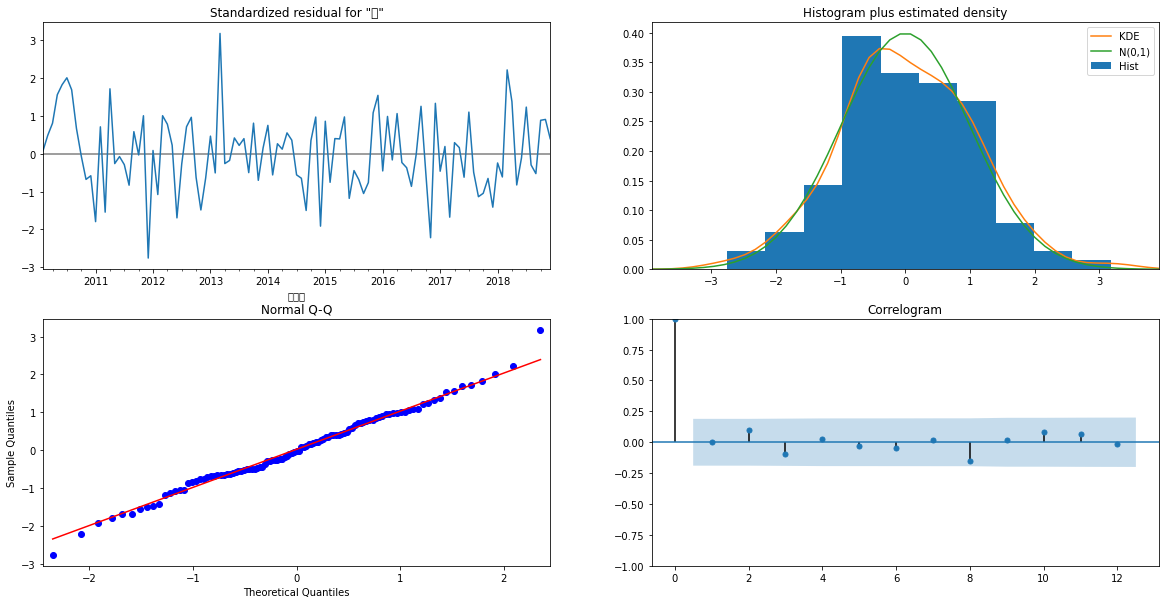

In [ ]:
plt.rc("figure",figsize=(20,10))
result_sarimax.plot_diagnostics(lags=12);